In [1]:
from endpoints import SofaScore
from datetime import datetime, timedelta
from helpers import send_request, generate_date_list, generate_live_games, fetch_event_data
import pandas as pd
import matplotlib.pyplot as plt


# Establish todays date
start_date = datetime.today().strftime('%Y-%m-%d')

# Establish an end date
end_date = '2023-01-01'

# Generate a list of dates
dates = generate_date_list(start_date,end_date)

# Create a list of endpoints from the list of dates and the Sofa base_endpoint
dated_endpoints = [SofaScore.BASE_ENDPOINT + date for date in dates]


In [2]:
from helpers import send_request, generate_date_list, generate_live_games, fetch_event_data

# store list of responses from the urls
responses = [response for response in await fetch_event_data(dated_endpoints) if response['events']]

# verify that the responses exist


In [3]:
print(responses[0])

{'events': [{'tournament': {'name': 'Premier League', 'slug': 'premier-league', 'category': {'name': 'England', 'slug': 'england', 'sport': {'name': 'Football', 'slug': 'football', 'id': 1}, 'id': 1, 'flag': 'england', 'alpha2': 'EN'}, 'uniqueTournament': {'name': 'Premier League', 'slug': 'premier-league', 'category': {'name': 'England', 'slug': 'england', 'sport': {'name': 'Football', 'slug': 'football', 'id': 1}, 'id': 1, 'flag': 'england', 'alpha2': 'EN'}, 'userCount': 0, 'id': 17, 'hasEventPlayerStatistics': True, 'crowdsourcingEnabled': False, 'hasPerformanceGraphFeature': False, 'displayInverseHomeAwayTeams': False}, 'priority': 599, 'id': 1}, 'season': {'name': 'Premier League 23/24', 'year': '23/24', 'editor': False, 'id': 52186}, 'roundInfo': {'round': 18}, 'customId': 'psP', 'status': {'code': 100, 'description': 'Ended', 'type': 'finished'}, 'winnerCode': 3, 'homeTeam': {'name': 'Aston Villa', 'slug': 'aston-villa', 'shortName': 'Aston Villa', 'sport': {'name': 'Football', 

In [10]:
def extract_event_data(response_array):

    # Initialize an empty list to store the event data
    event_data = []

    for response in response_array:
        # Filter out events that are not postponed

        events = [event for event in response['events'] if event['status']['type'] not in ['postponed', 'canceled']]
        
        # Loop through each event
        for event in events:   
                    
            # sometime score dicts have multiple scores, so just take max value; they should be same. 
            score_key = max(event['homeScore'], key = event['homeScore'].get) if event['homeScore'] else None
            
            # if no score obj, then skip
            if score_key:
                # Create a dictionary to store the relevant data for each event
                struct = {
                    'tournament' : event['tournament']['name'],  # Name of the tournament
                    'region' : event['tournament']['category']['name'],  # Region of the tournament
                    'home_team' : event['homeTeam']['name'],  # Name of the home team
                    'away_team' : event['awayTeam']['name'],  # Name of the away team
                    'home_score': event['homeScore'][score_key],  # Current score of the home team
                    'away_score': event['awayScore'][score_key],  # Current score of the away team
                    'total'     : event['homeScore'][score_key] + event['awayScore'][score_key],  # Total score
                    'start_timeestamp' : event['startTimestamp'],  # Start timestamp of the event
                    'game_id' : event['id'] # Unique Game ID
                    # 'start_datetime' : convert_timestamp_to_est_date(event['startTimestamp'])  # Start datetime of the event in EST
                }
                
                # Append the dictionary to the list of event data
                event_data.append(struct)
    
    # Return the list of event data
    return event_data

In [11]:
event_data = extract_event_data(responses)

In [12]:
# print(event_data[0])

{'tournament': 'Premier League', 'region': 'England', 'home_team': 'Aston Villa', 'away_team': 'Sheffield United', 'home_score': 1, 'away_score': 1, 'total': 2, 'start_timeestamp': 1703275200, 'game_id': 11352511}


In [6]:
def calculate_winrate(event_data, threshold, **kwargs):
    """
    Credit to: https://github.com/rushcapital
    This function calculates the winrate of the events based on a given threshold.
    Parameters:
    event_data (list): A list of dictionaries containing event data.
    threshold (float): The threshold value to calculate the winrate.
    **kwargs: Additional filters to apply on the data.

    Returns:
    float: The calculated winrate.
    """

    # Convert the event data into a pandas DataFrame
    df = pd.DataFrame(event_data).drop_duplicates().reset_index(drop=True)
    
    # If there are additional filters, create a query string
    query = ' & '.join([f"{k} == '{v}'" for k, v in kwargs.items()]) if kwargs else None
    
    # Create the under and over queries based on the threshold and additional filters
    # The under query selects events where the total score is less than the threshold
    under_query = f"{query} & total < {threshold}" if query else f'total < {threshold}'
    
    # The over query selects events where the total score is more than the threshold
    over_query = f"{query} & total > {threshold}" if query else f'total > {threshold}'
    
    # Apply the under and over queries to the DataFrame
    under = df.query(under_query)
    over = df.query(over_query)
    
    # Calculate the winrate as the ratio of under events to the total number of events
    # If there are no events, the winrate is 0
    winrate = round(under.shape[0] / (under.shape[0] + over.shape[0]),3) if (under.shape[0] + over.shape[0]) != 0 else 0
    
    struct = {
        'total_games' : under.shape[0] + over.shape[0],
        'under_wins' : under.shape[0],
        'under_winrate' : winrate
    }

    return struct


In [7]:
winrate_england_struct = calculate_winrate(event_data, threshold=3.5, region='England')


print(winrate_england_struct)


{'total_games': 3101, 'under_wins': 2120, 'under_winrate': 0.684}


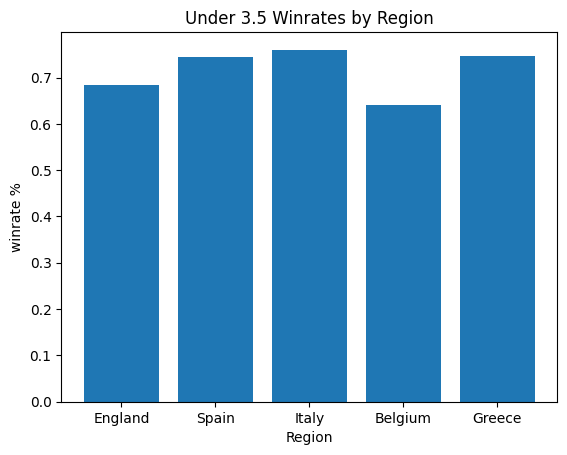

In [8]:
# winrate_struct = calculate_winrate(event_data, threshold=3.5)
import pandas as pd

winrate_england_struct = calculate_winrate(event_data, threshold=3.5, region='England')
winrate_spain_struct = calculate_winrate(event_data, threshold=3.5, region='Spain')
winrate_italy_struct = calculate_winrate(event_data, threshold=3.5, region='Italy')
winrate_belgium_struct = calculate_winrate(event_data, threshold=3.5, region='Belgium')
winrate_greece_struct = calculate_winrate(event_data, threshold=3.5, region='Greece')

Data = pd.DataFrame([winrate_england_struct, winrate_spain_struct, winrate_italy_struct, winrate_belgium_struct, winrate_greece_struct])

import matplotlib.pyplot as plt

regions = ['England', 'Spain', 'Italy', 'Belgium', 'Greece']
winrates = Data['under_winrate']
x = range(len(regions))
plt.bar(regions, winrates)
plt.title('Under 3.5 Winrates by Region')
plt.xlabel('Region')
plt.ylabel('winrate %')
plt.show()




In [9]:


# function to extract all regions

def extract_regions(response_array):

    unique_regions = []

    # Iterate over the response_array. (This should be event_data)

    for data in response_array:
        region = data['region']

        # If the Region exists in the unique_regions list, skip over it, else, append it.
        if region in unique_regions:
            continue
        else:
            unique_regions.append(region)

    # Return the list.
    return unique_regions

# Call to store the unique list of regions
list_of_regions = extract_regions(event_data)


